In [ ]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

Вот тут загружаем файлы. Неважно как, главное, чтобы архив heterogenity_zip.zip лежал в рабочей области, ну, и распаковать его

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp drive/MyDrive/RheologyStructure/heterogeneity_zip.zip heterogeneity_zip.zip
!unzip heterogeneity_zip.zip

Archive:  heterogeneity_zip.zip
replace heterogeneity/seismograms/25.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Смотрим, сколько всего сейсмограмм

In [ ]:
filenames = sorted(os.listdir("heterogeneity/masks"))
max_num = np.max([int(f[:-4]) for f in filenames]) + 1
print(f"Total number of seismograms is {max_num}")

Total number of seismograms is 1000


Загружаем сейсмограммы, рескейлим маски, чтобы они были +- одного размера

In [ ]:
seismograms_dict = {i:np.load(f"heterogeneity/seismograms/{i}.npy").transpose(1, 2, 0) for i in range(max_num)}

def rescale_mask(mask):
  return mask[::2, ::2] + mask[1::2, ::2] + mask[::2, 1::2] + mask[1::2, 1::2] >= 2

masks_dict = {i:rescale_mask(np.load(f"heterogeneity/masks/{i}.npy")) for i in range(max_num)}

Смотрим на пример маски

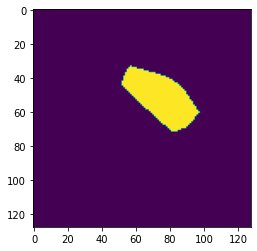

In [ ]:
plt.imshow(masks_dict[500])

In [ ]:
seismograms = np.array([seismograms_dict[i] for i in seismograms_dict])
masks = np.array([masks_dict[i] for i in masks_dict]).reshape(-1, 128 ** 2)
masks = masks * 1.
# new_seismograms = np.zeros((1000, 128, 128, 3))
# new_seismograms[:,:,:,:2] = seismograms
# seismograms = new_seismograms
seismograms.shape

(1000, 128, 128, 2)

Есть репозиторий с кучей непредобученных сеток с допустимыми изменениями входных параметров, его и юзаем

In [ ]:
!pip install git+https://github.com/divamgupta/image-segmentation-keras

In [ ]:
# !wget https://github.com/divamgupta/datasets/releases/download/seg/dataset1.zip && unzip dataset1.zip

In [ ]:
from keras_segmentation.models.segnet import vgg_segnet, segnet
import tensorflow as tf
from keras import backend as K

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [ ]:
# seismograms.shape

Т. к. выборки насбаллансированные, используем взвешенную категориальную кросс-энтропию как функцию потерь

In [ ]:
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

Стоит поиграть с параметром w - как раз весом в нашей функции потерь

In [ ]:
w = 1 - np.mean(gt[:,:,0]) 
weights = (w, 1 - w)
loss = weighted_categorical_crossentropy(weights)

In [ ]:
model_sgn = segnet(n_classes=2, input_height=128, input_width=128, encoder_level=2, channels=2)
model = tf.keras.Sequential()
model.add(model_sgn)
model.add(tf.keras.layers.Reshape((128 * 128, 2))) 
model.add(tf.keras.layers.Softmax(axis=-1,))
gt = np.array([masks, 1 - masks]).transpose(1, 2, 0)

In [ ]:
model.compile(loss=loss,optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
history = model.fit(seismograms[:900], gt[:900], validation_data=(seismograms[900:], gt[900:]), batch_size=100, epochs=500)

График потерь на валидационной выборке

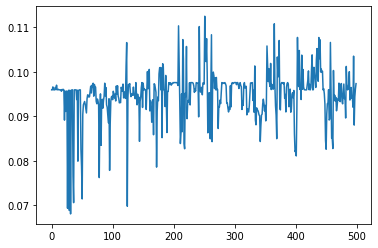

In [ ]:
plt.plot(np.arange(len(history.history["val_loss"])), history.history["val_loss"])

То же самое, но с точностью

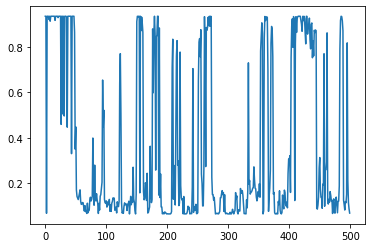

In [ ]:
plt.plot(np.arange(len(history.history["val_accuracy"])), history.history["val_accuracy"])

Наконец, играем с картинками. Имеет смысл менять порог вероятности thx

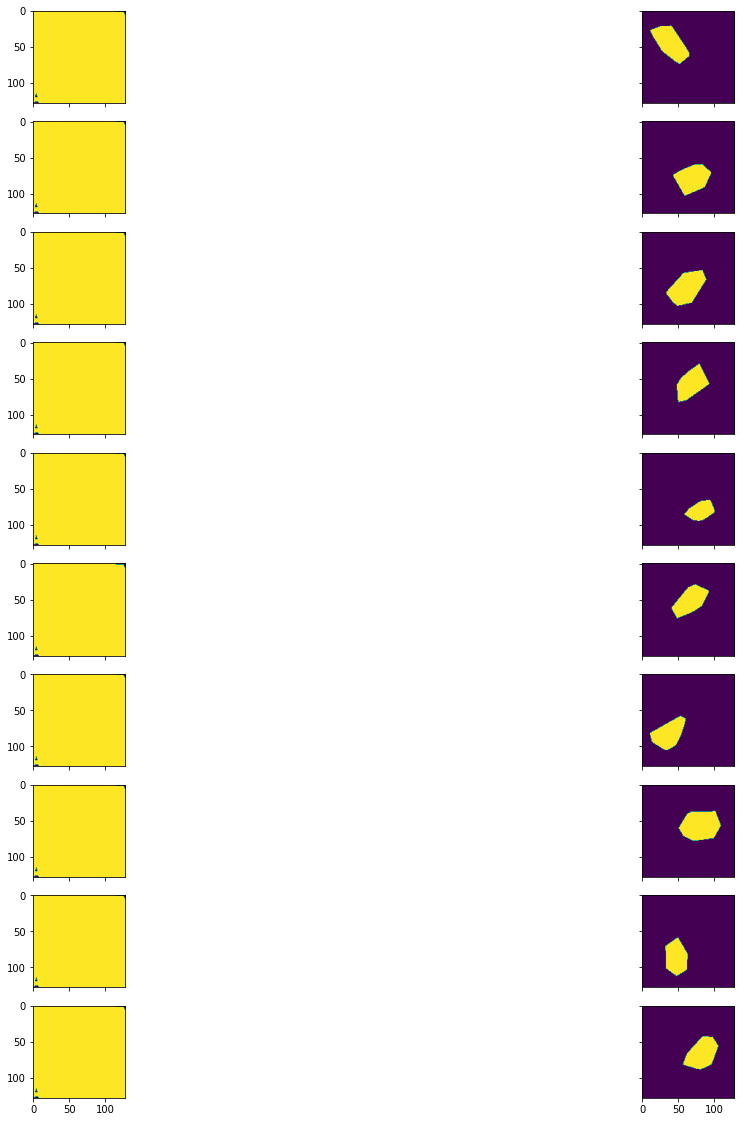

In [ ]:
predicts = model.predict(seismograms[-10:]).reshape(-1, 128, 128, 2)
thx = 0.6

fig, axis = plt.subplots(10, 2, sharex=True, sharey=True, figsize=(20, 20))
fig.patch.set_visible(False)
#axis.axis('off')
for i in range(10):
  axis[i][0].imshow(predicts[-10 + i,:,:,0] >= thx)
  axis[i][1].imshow(gt[-10 + i,:,0].reshape(128, 128) >= 0.5)

In [ ]:
for i in range(-9, 0, 1):
  print(i)

-9
-8
-7
-6
-5
-4
-3
-2
-1


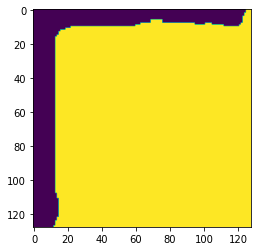

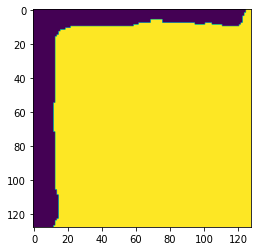

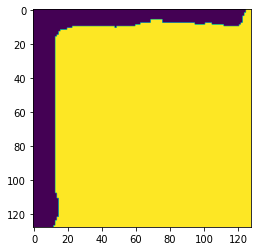

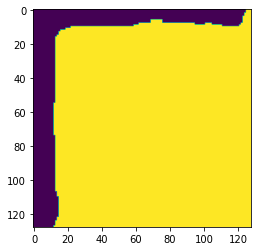

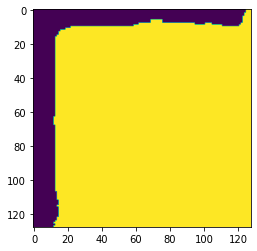

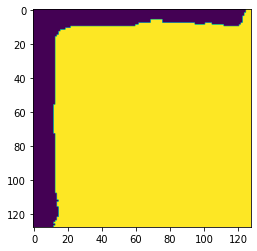

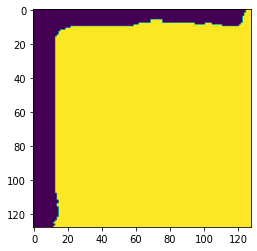

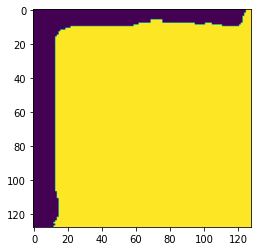

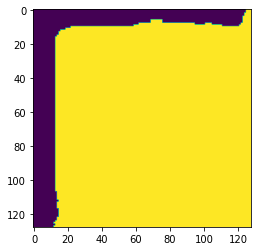

In [ ]:
predicts = model.predict(seismograms[-10:]).reshape(-1, 128, 128, 2)
for i in range(-9, 0, 1):
  plt.imshow(predicts[-i,:,:,0] >= 0.5)
  plt.show()

In [ ]:
masks_dict[500].shape

(128, 128)